# Обучение одной части

Всего частей 4. Потребуется 4 раза запустить эту тетрадку, но с разным `number`

In [1]:
number = 3

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

In [3]:
X = dd.read_csv(f'my_data/chunks/X_{number}.csv')
X.head(3)

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,3244377,4.0,1542574800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,3244377,2.0,1540155600,-86.119971,-370.879112,-100.060786,-423.486798,-105.478246,-444.59179,-16.08618,...,1968.626154,319.229208,-19.996269,-33.630448,-37.747724,-23.832889,-0.694428,-12.175933,-0.45614,0.0
2,3244384,2.0,1544389200,-96.799971,-242.569112,-110.740786,-295.176798,-116.158246,-316.28179,-16.08618,...,-740.373846,-568.770792,-11.996269,-36.630448,-124.747724,181.167111,-0.694428,-12.175933,8.54386,0.0


In [4]:
y = dd.read_csv(f'my_data/chunks/y_{number}.csv')['target']
y.head(3)

0    1.0
1    0.0
2    0.0
Name: target, dtype: float64

In [5]:
sum(y.isna())

0

In [6]:
((X.shape[0].compute(), X.shape[1]), len(y))

((207884, 256), 207884)

In [7]:
# , 'buy_time'
X_plain = X.drop(['id'], axis=1).compute()
y_plain = y.compute()

In [8]:
sum(y_plain)

10603.0

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

GradientBoostingClassifier(
    
ccp_alpha=0.0,

criterion='friedman_mse',

init=None,

learning_rate=0.1,

loss='deviance',

max_depth=3,

max_features=None,

max_leaf_nodes=None,

min_impurity_decrease=0.0,

min_impurity_split=None,

min_samples_leaf=1,

min_samples_split=2,

min_weight_fraction_leaf=0.0,

n_estimators=1000,

n_iter_no_change=None,

presort='deprecated',

random_state=21,

subsample=1.0,

tol=0.0001,

validation_fraction=0.1,

verbose=0,

warm_start=False

)

In [10]:
gb = GradientBoostingClassifier(random_state=1, max_depth=256, n_estimators=128)
gb.fit(X_plain, y_plain)

GradientBoostingClassifier(max_depth=256, n_estimators=128, random_state=1)

In [11]:
pred = gb.predict(X_plain)

In [12]:
sum(pred)

# 13923.0

8978.0

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

In [14]:
f1_score(pred, y_plain)

# 0.9999034842196699
# ...
# 0.5194019531587589

0.906899545477759

In [15]:
pred_proba = gb.predict_proba(X_plain)[:, 1]

In [16]:
test_number = 0 if number > 0 else 1

In [17]:
# , 'buy_time'
X_test = dd.read_csv(f'my_data/chunks/X_{test_number}.csv').drop(['id'], axis=1).compute()
y_test = dd.read_csv(f'my_data/chunks/y_{test_number}.csv')['target'].compute()

In [18]:
pred_test = gb.predict(X_test)
pred_test_proba = gb.predict_proba(X_test)[:, 1]

In [25]:
(
    f1_score(pred_test, y_test),
    precision_score(pred_test, y_test),
    recall_score(pred_test, y_test)
)

# 0.4039633125795005
# 0.37668466476765444
# 0.39120021289807505
# 0.41393987762702844
# 0.4198608012254821
# (0.20936927505888514, 0.15441034549314805, 0.3250711093051605)
# (0.44649482843539656, 0.4084955539533766, 0.4922887553399464)
# (0.35769109452213227, 0.2650496026593258, 0.5498922413793104)
# (0.37944388014220415, 0.31044512543499714, 0.4878785405273039)
# (0.35769109452213227, 0.2650496026593258, 0.5498922413793104)

(0.35769109452213227, 0.2650496026593258, 0.5498922413793104)

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_test_proba)
beta = 0.75 # Отдаю предпочтение precision
fscore = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
f1score = (2 * precision * recall) / (precision + recall)
ind = np.argmax(fscore)
print('Best threshold = %f,\nF-Score = %.3f,\nF1-Score = %.3f,\nPrecision = %.3f,\nRecall = %.3f' %
       (thresholds[ind], 
        fscore[ind],
        f1score[ind],
        precision[ind],
        recall[ind]))

Best threshold = 0.000126,
F-Score = 0.489,
F1-Score = 0.505,
Precision = 0.452,
Recall = 0.571


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

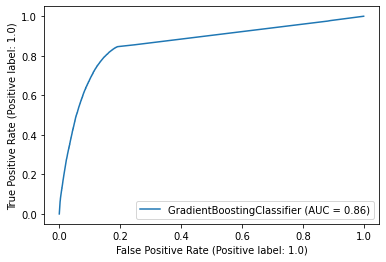

In [22]:
RocCurveDisplay.from_estimator(gb, X_test, y_test)
plt.show()

In [23]:
import pickle

In [24]:
pickle.dump(gb, open(f'my_data/models/{number}.pickle', 'wb'))